In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [1]:

from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()


In [4]:
X = pd.DataFrame(housing.data)
y = pd.DataFrame(housing.target)
features = housing.feature_names
target_feature = housing.target_names
X.columns = features
y.columns = target_feature
df = pd.concat([X,y],axis=1)
df.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


In [ ]:
# Population,AvgOccup

In [6]:
# combine Latitude & Lognitude - Haversine distance

from math import radians, cos, sin, asin, sqrt

def single_pt_haversine(lat, lng, degrees=True):
    """
    'Single-point' Haversine: Calculates the great circle distance
    between a point on Earth and the (0, 0) lat-long coordinate
    """
    r = 6371 # Earth's radius (km). Have r = 3956 if you want miles

    # Convert decimal degrees to radians
    if degrees:
        lat, lng = map(radians, [lat, lng])

    # 'Single-point' Haversine formula
    a = sin(lat/2)**2 + cos(lat) * sin(lng/2)**2
    d = 2 * r * asin(sqrt(a)) 

    return d




In [7]:
df['Distance'] = [
    single_pt_haversine(x, y) for x, y in zip(df.Latitude, df.Longitude)]


In [8]:
df['OtherRoom'] = df['AveRooms'] - df['AveBedrms']

In [9]:
df.drop(columns=['Latitude','Longitude','AveRooms'],inplace=True)

In [10]:
df= df.apply(lambda x : x.astype("int64"),axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   MedInc       20640 non-null  int64
 1   HouseAge     20640 non-null  int64
 2   AveBedrms    20640 non-null  int64
 3   Population   20640 non-null  int64
 4   AveOccup     20640 non-null  int64
 5   MedHouseVal  20640 non-null  int64
 6   Distance     20640 non-null  int64
 7   OtherRoom    20640 non-null  int64
dtypes: int64(8)
memory usage: 1.3 MB


<Figure size 1500x1000 with 0 Axes>

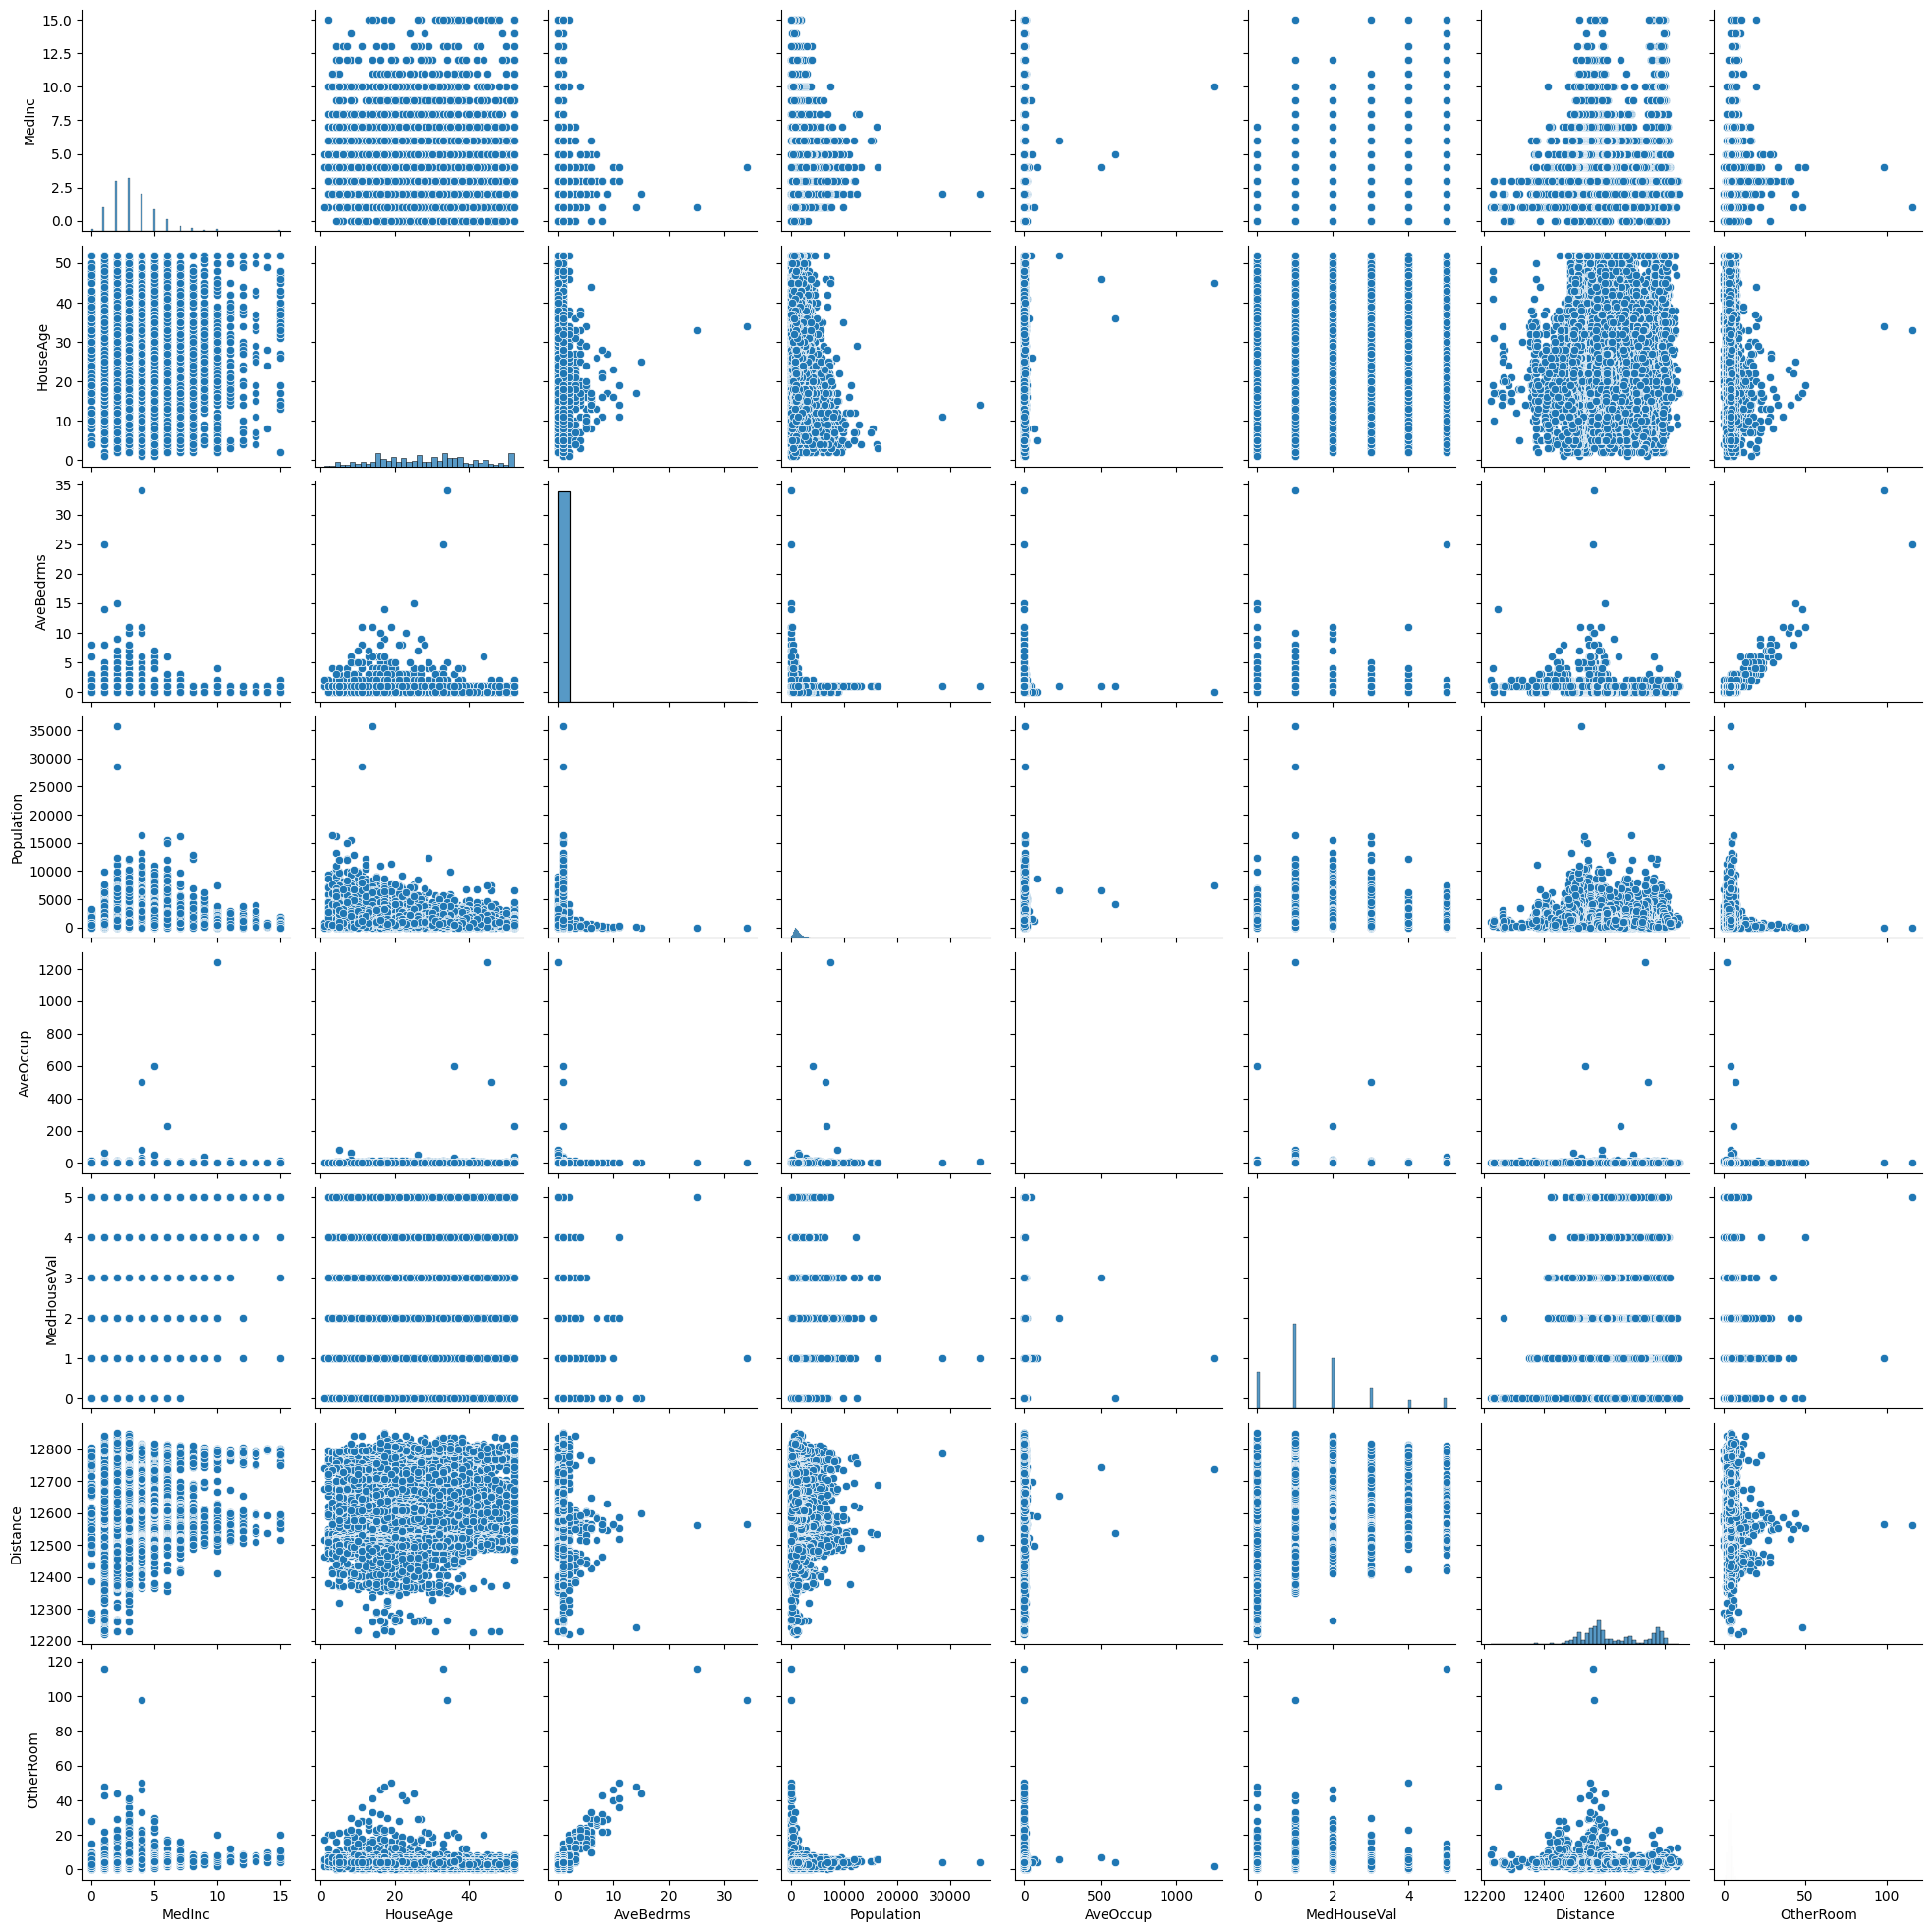

In [51]:
plt.figure(figsize=(15,10))
sns.pairplot(df)
plt.show()

In [82]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["MedHouseVal"],axis=1)
y = df["MedHouseVal"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(16512, 7) (16512,) (4128, 7) (4128,)


In [83]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import mae,mse
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler


In [141]:
model = Sequential()
layers = [8,64,128,32,64,1]
n = X_train.shape[1] # number of features
model.add(Dense(units=layers[0],input_shape=(n,),
                activation='elu',kernel_initializer='he_normal'))
model.add(Dense(units=layers[1],activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=layers[2],activation='elu',kernel_initializer='he_normal'))
model.add(Dense(units=layers[3],activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=layers[4],activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=layers[5],activation='linear'))

In [142]:
#adam = Adam(learning_rate=0.001)
# define SGD optimizer
sgd = SGD(learning_rate=0.0, momentum=0.9)
model.compile(loss='mse',optimizer=sgd,metrics=['mse'])

In [126]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 8)                 64        
                                                                 
 dense_67 (Dense)            (None, 64)                576       
                                                                 
 batch_normalization_11 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_68 (Dense)            (None, 128)               8320      
                                                                 
 dense_69 (Dense)            (None, 32)                4128      
                                                                 
 dropout_22 (Dropout)        (None, 32)                0         
                                                     

In [143]:
import math

def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * tf.math.pow(drop, tf.math.floor((epoch)/epochs_drop))
    return lrate

def exp_decay(epoch):
    initial_lrate = 0.01
    k = 0.1
    lrate = initial_lrate * tf.math.exp(-k*epoch)
    return lrate
    
lrate = LearningRateScheduler(exp_decay)

# avoid NaN in loss - set lower initial_learning_rate
# here mse + step_decay works better
callbacks_ = [EarlyStopping(patience=2),lrate]

In [144]:
history =model.fit(x=X_train_scaled,y=y_train,epochs=500,
                   validation_split=0.2,batch_size=8,callbacks=callbacks_)

Epoch 1/500
1652/1652 [==============================] - 9s 4ms/step - loss: 1.4448 - mse: 1.4448 - val_loss: 1.1339 - val_mse: 1.1339 - lr: 0.0100
Epoch 2/500
1652/1652 [==============================] - 9s 5ms/step - loss: 1.2785 - mse: 1.2785 - val_loss: 1.6507 - val_mse: 1.6507 - lr: 0.0090
Epoch 3/500
1652/1652 [==============================] - 8s 5ms/step - loss: 1.2298 - mse: 1.2298 - val_loss: 1.1678 - val_mse: 1.1678 - lr: 0.0082


In [110]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse', 'lr'])

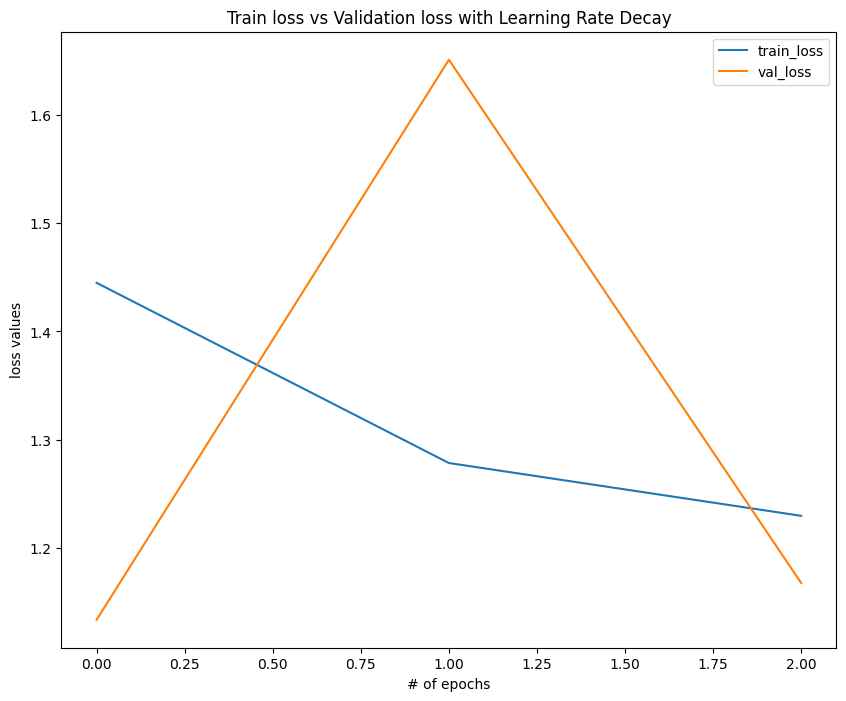

In [145]:
plt.figure(figsize=(10,8))
plt.plot(history.history["loss"],label="train_loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.xlabel("# of epochs")
plt.ylabel("loss values")
plt.title("Train loss vs Validation loss with Learning Rate Decay")
plt.legend()
plt.show()

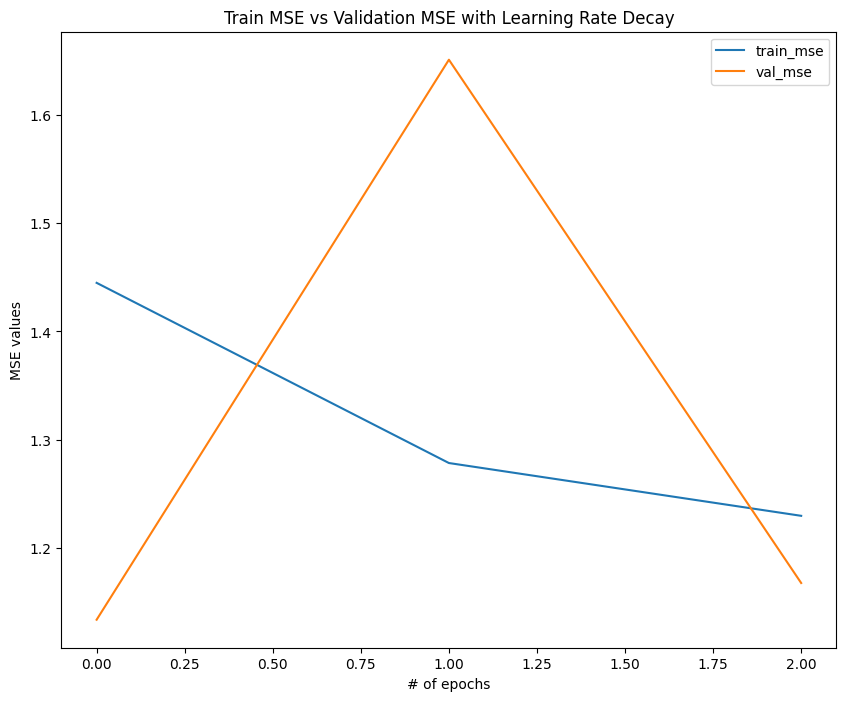

In [146]:
plt.figure(figsize=(10,8))
plt.plot(history.history["mse"],label="train_mse")
plt.plot(history.history["val_mse"],label="val_mse")
plt.xlabel("# of epochs")
plt.ylabel('MSE values')
plt.title("Train MSE vs Validation MSE with Learning Rate Decay")
plt.legend()
plt.show()

In [147]:
y_pred = model.predict(X_test_scaled)

129/129 [==============================] - 1s 3ms/step


In [148]:
from sklearn.metrics import mean_squared_error,r2_score

mse = mean_squared_error(y_test,y_pred)
score = r2_score(y_test,y_pred)
print(mse,score)

1.129208902861511 0.2799653538576554


In [33]:
# Adam performs way better

# 0.8157897915816121 0.479815548372414
# 0.727657398807925 0.5360127463254863

In [ ]:
#